In [ ]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
#Keras Sequential API
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
optimizer = Adam(lr=0.001)
loss = "categorical_crossentropy"
from keras import backend
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
metrics=["accuracy", 'mse', 'mape', rmse]
model.compile(optimizer = optimizer , loss = loss, metrics = metrics)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # nv # Try to make the model more sensitive to Melanocytic nevi
    5: 1.0, # mel
    6: 1.0, # vasc
}
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last', 
                                    validation_split=0.0, 
                                    interpolation_order=1, 
                                    dtype='float32')
augmented_data.fit(x_train)
epochs = 50
batch_size = 10
steps_per_epoch = len(x_train) / 10
import time
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
csv_logger = CSVLogger('../logs/original_cnn_training.log', separator=',', append=False)
# history = model.fit_generator(augmented_data.flow(x_train, y_train, batch_size = batch_size),
#                               epochs = epochs, 
#                               verbose = 1,
#                               class_weight = class_weights,
#                               validation_data = (x_validate, y_validate), 
#                               steps_per_epoch = steps_per_epoch,
#                               callbacks = [reduce_lr, time_callback, csv_logger])

batch_size = 64
epochs = 50
history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_validate.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 75, 100, 32)       896       
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 50, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 37, 50, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 50, 64)        36928     
                                                      

/var/folders/5l/_xcxp8dj3jg8wqbs9w6t88600000gn/T/ipykernel_4292/3496251301.py:103: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 1.6219 - accuracy: 0.3532 - mse: 0.1065 - mape: 106069104.0000 - rmse: 0.3147WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 65s 342ms/step - loss: 1.6219 - accuracy: 0.3532 - mse: 0.1065 - mape: 106069104.0000 - rmse: 0.3147 - val_loss: 1.3200 - val_accuracy: 0.4869 - val_mse: 0.0905 - val_mape: 91484616.0000 - val_rmse: 0.2767 - lr: 0.0010
Epoch 2/50
175/175 [==============================] - ETA: 0s - loss: 1.3680 - accuracy: 0.4655 - mse: 0.0929 - mape: 92825232.0000 - rmse: 0.2824WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 64s 362ms/step - loss: 1.3680 - accuracy: 0.4655 - mse: 0.0929 - mape: 92825232.0000 - rmse: 0.2824 - val_loss: 1.1853 - val_accuracy: 0.5378 - val_mse: 0.0836 - val_mape: 86906624.0000 - val_rmse: 0.2641 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - ETA: 0s - loss: 1.2388 - accuracy: 0.5196 - mse: 0.0854 - mape: 85825712.0000 - rmse: 0.2638WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 66s 376ms/step - loss: 1.2388 - accuracy: 0.5196 - mse: 0.0854 - mape: 85825712.0000 - rmse: 0.2638 - val_loss: 1.0578 - val_accuracy: 0.5879 - val_mse: 0.0761 - val_mape: 80363048.0000 - val_rmse: 0.2473 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - ETA: 0s - loss: 1.1781 - accuracy: 0.5479 - mse: 0.0816 - mape: 81984384.0000 - rmse: 0.2539WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 85s 483ms/step - loss: 1.1781 - accuracy: 0.5479 - mse: 0.0816 - mape: 81984384.0000 - rmse: 0.2539 - val_loss: 0.9919 - val_accuracy: 0.6185 - val_mse: 0.0709 - val_mape: 73977984.0000 - val_rmse: 0.2307 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - ETA: 0s - loss: 1.1223 - accuracy: 0.5599 - mse: 0.0786 - mape: 78699208.0000 - rmse: 0.2452WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 83s 474ms/step - loss: 1.1223 - accuracy: 0.5599 - mse: 0.0786 - mape: 78699208.0000 - rmse: 0.2452 - val_loss: 1.0099 - val_accuracy: 0.5938 - val_mse: 0.0733 - val_mape: 74834544.0000 - val_rmse: 0.2352 - lr: 0.0010
Epoch 6/50
175/175 [==============================] - ETA: 0s - loss: 1.0952 - accuracy: 0.5806 - mse: 0.0765 - mape: 76996936.0000 - rmse: 0.2405WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 78s 445ms/step - loss: 1.0952 - accuracy: 0.5806 - mse: 0.0765 - mape: 76996936.0000 - rmse: 0.2405 - val_loss: 0.9380 - val_accuracy: 0.6308 - val_mse: 0.0682 - val_mape: 71531880.0000 - val_rmse: 0.2243 - lr: 0.0010
Epoch 7/50
175/175 [==============================] - ETA: 0s - loss: 1.0545 - accuracy: 0.5916 - mse: 0.0744 - mape: 74936112.0000 - rmse: 0.2353WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 77s 441ms/step - loss: 1.0545 - accuracy: 0.5916 - mse: 0.0744 - mape: 74936112.0000 - rmse: 0.2353 - val_loss: 0.9459 - val_accuracy: 0.6301 - val_mse: 0.0682 - val_mape: 67500392.0000 - val_rmse: 0.2145 - lr: 0.0010
Epoch 8/50
175/175 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.6023 - mse: 0.0722 - mape: 72496016.0000 - rmse: 0.2289WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 78s 443ms/step - loss: 1.0167 - accuracy: 0.6023 - mse: 0.0722 - mape: 72496016.0000 - rmse: 0.2289 - val_loss: 0.8866 - val_accuracy: 0.6555 - val_mse: 0.0654 - val_mape: 69916632.0000 - val_rmse: 0.2211 - lr: 0.0010
Epoch 9/50
175/175 [==============================] - ETA: 0s - loss: 1.0009 - accuracy: 0.6099 - mse: 0.0714 - mape: 71873152.0000 - rmse: 0.2271WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 82s 469ms/step - loss: 1.0009 - accuracy: 0.6099 - mse: 0.0714 - mape: 71873152.0000 - rmse: 0.2271 - val_loss: 0.8715 - val_accuracy: 0.6606 - val_mse: 0.0628 - val_mape: 62997504.0000 - val_rmse: 0.2025 - lr: 0.0010
Epoch 10/50
175/175 [==============================] - ETA: 0s - loss: 0.9934 - accuracy: 0.6112 - mse: 0.0709 - mape: 71001336.0000 - rmse: 0.2250WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 82s 467ms/step - loss: 0.9934 - accuracy: 0.6112 - mse: 0.0709 - mape: 71001336.0000 - rmse: 0.2250 - val_loss: 0.8657 - val_accuracy: 0.6722 - val_mse: 0.0632 - val_mape: 64431576.0000 - val_rmse: 0.2049 - lr: 0.0010
Epoch 11/50
175/175 [==============================] - ETA: 0s - loss: 0.9631 - accuracy: 0.6321 - mse: 0.0685 - mape: 69101152.0000 - rmse: 0.2192WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 81s 460ms/step - loss: 0.9631 - accuracy: 0.6321 - mse: 0.0685 - mape: 69101152.0000 - rmse: 0.2192 - val_loss: 0.8456 - val_accuracy: 0.6897 - val_mse: 0.0609 - val_mape: 61821188.0000 - val_rmse: 0.1981 - lr: 0.0010
Epoch 12/50
175/175 [==============================] - ETA: 0s - loss: 0.9524 - accuracy: 0.6304 - mse: 0.0683 - mape: 68739216.0000 - rmse: 0.2184WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 80s 458ms/step - loss: 0.9524 - accuracy: 0.6304 - mse: 0.0683 - mape: 68739216.0000 - rmse: 0.2184 - val_loss: 0.8447 - val_accuracy: 0.6773 - val_mse: 0.0610 - val_mape: 62487456.0000 - val_rmse: 0.1991 - lr: 0.0010
Epoch 13/50
175/175 [==============================] - ETA: 0s - loss: 0.9538 - accuracy: 0.6315 - mse: 0.0685 - mape: 68451424.0000 - rmse: 0.2179WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 83s 470ms/step - loss: 0.9538 - accuracy: 0.6315 - mse: 0.0685 - mape: 68451424.0000 - rmse: 0.2179 - val_loss: 0.8621 - val_accuracy: 0.6730 - val_mse: 0.0626 - val_mape: 63555388.0000 - val_rmse: 0.2035 - lr: 0.0010
Epoch 14/50
175/175 [==============================] - ETA: 0s - loss: 0.9371 - accuracy: 0.6388 - mse: 0.0668 - mape: 67332624.0000 - rmse: 0.2139WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 90s 512ms/step - loss: 0.9371 - accuracy: 0.6388 - mse: 0.0668 - mape: 67332624.0000 - rmse: 0.2139 - val_loss: 0.7921 - val_accuracy: 0.6933 - val_mse: 0.0592 - val_mape: 61404924.0000 - val_rmse: 0.1974 - lr: 0.0010
Epoch 15/50
175/175 [==============================] - ETA: 0s - loss: 0.9205 - accuracy: 0.6474 - mse: 0.0664 - mape: 66681272.0000 - rmse: 0.2130WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 86s 491ms/step - loss: 0.9205 - accuracy: 0.6474 - mse: 0.0664 - mape: 66681272.0000 - rmse: 0.2130 - val_loss: 0.7967 - val_accuracy: 0.6948 - val_mse: 0.0588 - val_mape: 60487520.0000 - val_rmse: 0.1951 - lr: 0.0010
Epoch 16/50
175/175 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.6546 - mse: 0.0647 - mape: 65182948.0000 - rmse: 0.2088WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 87s 495ms/step - loss: 0.8959 - accuracy: 0.6546 - mse: 0.0647 - mape: 65182948.0000 - rmse: 0.2088 - val_loss: 0.8001 - val_accuracy: 0.6984 - val_mse: 0.0578 - val_mape: 56571188.0000 - val_rmse: 0.1848 - lr: 0.0010
Epoch 17/50
175/175 [==============================] - ETA: 0s - loss: 0.9079 - accuracy: 0.6537 - mse: 0.0654 - mape: 65739524.0000 - rmse: 0.2108WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 87s 499ms/step - loss: 0.9079 - accuracy: 0.6537 - mse: 0.0654 - mape: 65739524.0000 - rmse: 0.2108 - val_loss: 0.7578 - val_accuracy: 0.6824 - val_mse: 0.0578 - val_mape: 57748940.0000 - val_rmse: 0.1890 - lr: 0.0010
Epoch 18/50
175/175 [==============================] - ETA: 0s - loss: 0.8847 - accuracy: 0.6513 - mse: 0.0640 - mape: 64137596.0000 - rmse: 0.2058WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 94s 539ms/step - loss: 0.8847 - accuracy: 0.6513 - mse: 0.0640 - mape: 64137596.0000 - rmse: 0.2058 - val_loss: 0.7797 - val_accuracy: 0.6955 - val_mse: 0.0579 - val_mape: 58364260.0000 - val_rmse: 0.1900 - lr: 0.0010
Epoch 19/50
175/175 [==============================] - ETA: 0s - loss: 0.8700 - accuracy: 0.6658 - mse: 0.0633 - mape: 63606784.0000 - rmse: 0.2050WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 90s 515ms/step - loss: 0.8700 - accuracy: 0.6658 - mse: 0.0633 - mape: 63606784.0000 - rmse: 0.2050 - val_loss: 0.7258 - val_accuracy: 0.7209 - val_mse: 0.0546 - val_mape: 56695932.0000 - val_rmse: 0.1847 - lr: 0.0010
Epoch 20/50
175/175 [==============================] - ETA: 0s - loss: 0.8595 - accuracy: 0.6643 - mse: 0.0622 - mape: 62621456.0000 - rmse: 0.2016WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 83s 472ms/step - loss: 0.8595 - accuracy: 0.6643 - mse: 0.0622 - mape: 62621456.0000 - rmse: 0.2016 - val_loss: 0.6905 - val_accuracy: 0.7304 - val_mse: 0.0522 - val_mape: 55034516.0000 - val_rmse: 0.1796 - lr: 0.0010
Epoch 21/50
175/175 [==============================] - ETA: 0s - loss: 0.8612 - accuracy: 0.6684 - mse: 0.0625 - mape: 62794364.0000 - rmse: 0.2026WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 92s 526ms/step - loss: 0.8612 - accuracy: 0.6684 - mse: 0.0625 - mape: 62794364.0000 - rmse: 0.2026 - val_loss: 0.7293 - val_accuracy: 0.7188 - val_mse: 0.0548 - val_mape: 55346052.0000 - val_rmse: 0.1821 - lr: 0.0010
Epoch 22/50
175/175 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.6693 - mse: 0.0629 - mape: 63080432.0000 - rmse: 0.2032WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 93s 530ms/step - loss: 0.8717 - accuracy: 0.6693 - mse: 0.0629 - mape: 63080432.0000 - rmse: 0.2032 - val_loss: 0.7241 - val_accuracy: 0.7355 - val_mse: 0.0533 - val_mape: 56908548.0000 - val_rmse: 0.1839 - lr: 0.0010
Epoch 23/50
175/175 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.6739 - mse: 0.0611 - mape: 61464952.0000 - rmse: 0.1987WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 105s 600ms/step - loss: 0.8346 - accuracy: 0.6739 - mse: 0.0611 - mape: 61464952.0000 - rmse: 0.1987 - val_loss: 0.6900 - val_accuracy: 0.7471 - val_mse: 0.0508 - val_mape: 53466368.0000 - val_rmse: 0.1731 - lr: 0.0010
Epoch 24/50
175/175 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.6779 - mse: 0.0611 - mape: 61435984.0000 - rmse: 0.1983WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 83s 473ms/step - loss: 0.8447 - accuracy: 0.6779 - mse: 0.0611 - mape: 61435984.0000 - rmse: 0.1983 - val_loss: 0.6451 - val_accuracy: 0.7580 - val_mse: 0.0477 - val_mape: 50531304.0000 - val_rmse: 0.1659 - lr: 0.0010
Epoch 25/50
175/175 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.6848 - mse: 0.0598 - mape: 60287820.0000 - rmse: 0.1952WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 85s 486ms/step - loss: 0.8222 - accuracy: 0.6848 - mse: 0.0598 - mape: 60287820.0000 - rmse: 0.1952 - val_loss: 0.6717 - val_accuracy: 0.7435 - val_mse: 0.0503 - val_mape: 52207128.0000 - val_rmse: 0.1720 - lr: 0.0010
Epoch 26/50
175/175 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.6911 - mse: 0.0586 - mape: 59125760.0000 - rmse: 0.1917WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 88s 505ms/step - loss: 0.8043 - accuracy: 0.6911 - mse: 0.0586 - mape: 59125760.0000 - rmse: 0.1917 - val_loss: 0.6903 - val_accuracy: 0.7369 - val_mse: 0.0516 - val_mape: 51903924.0000 - val_rmse: 0.1715 - lr: 0.0010
Epoch 27/50
175/175 [==============================] - ETA: 0s - loss: 0.8030 - accuracy: 0.6872 - mse: 0.0588 - mape: 59042160.0000 - rmse: 0.1919WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 94s 539ms/step - loss: 0.8030 - accuracy: 0.6872 - mse: 0.0588 - mape: 59042160.0000 - rmse: 0.1919 - val_loss: 0.6577 - val_accuracy: 0.7624 - val_mse: 0.0486 - val_mape: 49448188.0000 - val_rmse: 0.1629 - lr: 0.0010
Epoch 28/50
175/175 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.6954 - mse: 0.0584 - mape: 58517268.0000 - rmse: 0.1902WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 87s 496ms/step - loss: 0.7966 - accuracy: 0.6954 - mse: 0.0584 - mape: 58517268.0000 - rmse: 0.1902 - val_loss: 0.7054 - val_accuracy: 0.7209 - val_mse: 0.0535 - val_mape: 55042144.0000 - val_rmse: 0.1808 - lr: 0.0010
Epoch 29/50
175/175 [==============================] - ETA: 0s - loss: 0.7878 - accuracy: 0.7002 - mse: 0.0576 - mape: 57927960.0000 - rmse: 0.1883WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 87s 495ms/step - loss: 0.7878 - accuracy: 0.7002 - mse: 0.0576 - mape: 57927960.0000 - rmse: 0.1883 - val_loss: 0.6569 - val_accuracy: 0.7609 - val_mse: 0.0489 - val_mape: 50803460.0000 - val_rmse: 0.1675 - lr: 0.0010
Epoch 30/50
175/175 [==============================] - ETA: 0s - loss: 0.7739 - accuracy: 0.7042 - mse: 0.0568 - mape: 57317516.0000 - rmse: 0.1868WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 85s 487ms/step - loss: 0.7739 - accuracy: 0.7042 - mse: 0.0568 - mape: 57317516.0000 - rmse: 0.1868 - val_loss: 0.6324 - val_accuracy: 0.7733 - val_mse: 0.0463 - val_mape: 48368552.0000 - val_rmse: 0.1591 - lr: 0.0010
Epoch 31/50
175/175 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.7044 - mse: 0.0563 - mape: 56463800.0000 - rmse: 0.1842WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 86s 491ms/step - loss: 0.7631 - accuracy: 0.7044 - mse: 0.0563 - mape: 56463800.0000 - rmse: 0.1842 - val_loss: 0.6235 - val_accuracy: 0.7769 - val_mse: 0.0457 - val_mape: 48085536.0000 - val_rmse: 0.1590 - lr: 0.0010
Epoch 32/50
175/175 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.7103 - mse: 0.0565 - mape: 56772900.0000 - rmse: 0.1850WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 88s 500ms/step - loss: 0.7755 - accuracy: 0.7103 - mse: 0.0565 - mape: 56772900.0000 - rmse: 0.1850 - val_loss: 0.5856 - val_accuracy: 0.7936 - val_mse: 0.0436 - val_mape: 47468240.0000 - val_rmse: 0.1564 - lr: 0.0010
Epoch 33/50
175/175 [==============================] - ETA: 0s - loss: 0.7602 - accuracy: 0.7096 - mse: 0.0561 - mape: 56136308.0000 - rmse: 0.1835WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 88s 501ms/step - loss: 0.7602 - accuracy: 0.7096 - mse: 0.0561 - mape: 56136308.0000 - rmse: 0.1835 - val_loss: 0.6643 - val_accuracy: 0.7406 - val_mse: 0.0493 - val_mape: 48744332.0000 - val_rmse: 0.1614 - lr: 0.0010
Epoch 34/50
175/175 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.7188 - mse: 0.0547 - mape: 55062272.0000 - rmse: 0.1803WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 393s 2s/step - loss: 0.7442 - accuracy: 0.7188 - mse: 0.0547 - mape: 55062272.0000 - rmse: 0.1803 - val_loss: 0.6059 - val_accuracy: 0.7914 - val_mse: 0.0431 - val_mape: 44990900.0000 - val_rmse: 0.1504 - lr: 0.0010
Epoch 35/50
175/175 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.7124 - mse: 0.0552 - mape: 55318212.0000 - rmse: 0.1812WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 64s 363ms/step - loss: 0.7508 - accuracy: 0.7124 - mse: 0.0552 - mape: 55318212.0000 - rmse: 0.1812 - val_loss: 0.6365 - val_accuracy: 0.7544 - val_mse: 0.0466 - val_mape: 46345408.0000 - val_rmse: 0.1555 - lr: 0.0010
Epoch 36/50
175/175 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.7140 - mse: 0.0550 - mape: 55191644.0000 - rmse: 0.1808WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 76s 436ms/step - loss: 0.7475 - accuracy: 0.7140 - mse: 0.0550 - mape: 55191644.0000 - rmse: 0.1808 - val_loss: 0.5797 - val_accuracy: 0.7965 - val_mse: 0.0419 - val_mape: 43267412.0000 - val_rmse: 0.1451 - lr: 0.0010
Epoch 37/50
175/175 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.7154 - mse: 0.0546 - mape: 55028472.0000 - rmse: 0.1801WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 99s 562ms/step - loss: 0.7439 - accuracy: 0.7154 - mse: 0.0546 - mape: 55028472.0000 - rmse: 0.1801 - val_loss: 0.5701 - val_accuracy: 0.7812 - val_mse: 0.0431 - val_mape: 45418396.0000 - val_rmse: 0.1518 - lr: 0.0010
Epoch 38/50
175/175 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.7220 - mse: 0.0542 - mape: 54333456.0000 - rmse: 0.1780WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 89s 508ms/step - loss: 0.7409 - accuracy: 0.7220 - mse: 0.0542 - mape: 54333456.0000 - rmse: 0.1780 - val_loss: 0.5703 - val_accuracy: 0.7929 - val_mse: 0.0417 - val_mape: 42381708.0000 - val_rmse: 0.1410 - lr: 0.0010
Epoch 39/50
175/175 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.7272 - mse: 0.0529 - mape: 53045208.0000 - rmse: 0.1744WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 89s 507ms/step - loss: 0.7180 - accuracy: 0.7272 - mse: 0.0529 - mape: 53045208.0000 - rmse: 0.1744 - val_loss: 0.6043 - val_accuracy: 0.7783 - val_mse: 0.0446 - val_mape: 45357576.0000 - val_rmse: 0.1513 - lr: 0.0010
Epoch 40/50
175/175 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.7303 - mse: 0.0524 - mape: 52858972.0000 - rmse: 0.1734WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 89s 508ms/step - loss: 0.7142 - accuracy: 0.7303 - mse: 0.0524 - mape: 52858972.0000 - rmse: 0.1734 - val_loss: 0.5792 - val_accuracy: 0.7820 - val_mse: 0.0426 - val_mape: 42840996.0000 - val_rmse: 0.1438 - lr: 0.0010
Epoch 41/50
175/175 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7354 - mse: 0.0513 - mape: 51581828.0000 - rmse: 0.1700WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 323s 2s/step - loss: 0.6916 - accuracy: 0.7354 - mse: 0.0513 - mape: 51581828.0000 - rmse: 0.1700 - val_loss: 0.6119 - val_accuracy: 0.7616 - val_mse: 0.0468 - val_mape: 46785868.0000 - val_rmse: 0.1580 - lr: 0.0010
Epoch 42/50
175/175 [==============================] - ETA: 0s - loss: 0.7122 - accuracy: 0.7262 - mse: 0.0525 - mape: 52762636.0000 - rmse: 0.1739WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 68s 387ms/step - loss: 0.7122 - accuracy: 0.7262 - mse: 0.0525 - mape: 52762636.0000 - rmse: 0.1739 - val_loss: 0.5694 - val_accuracy: 0.7820 - val_mse: 0.0425 - val_mape: 43404476.0000 - val_rmse: 0.1457 - lr: 0.0010
Epoch 43/50
175/175 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7331 - mse: 0.0515 - mape: 51463620.0000 - rmse: 0.1699WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 72s 411ms/step - loss: 0.6924 - accuracy: 0.7331 - mse: 0.0515 - mape: 51463620.0000 - rmse: 0.1699 - val_loss: 0.6258 - val_accuracy: 0.7696 - val_mse: 0.0463 - val_mape: 46826140.0000 - val_rmse: 0.1570 - lr: 0.0010
Epoch 44/50
175/175 [==============================] - ETA: 0s - loss: 0.7008 - accuracy: 0.7281 - mse: 0.0519 - mape: 52115612.0000 - rmse: 0.1715WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 111s 633ms/step - loss: 0.7008 - accuracy: 0.7281 - mse: 0.0519 - mape: 52115612.0000 - rmse: 0.1715 - val_loss: 0.5579 - val_accuracy: 0.7936 - val_mse: 0.0416 - val_mape: 41034652.0000 - val_rmse: 0.1379 - lr: 0.0010
Epoch 45/50
175/175 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7378 - mse: 0.0514 - mape: 51485384.0000 - rmse: 0.1698WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 95s 540ms/step - loss: 0.6962 - accuracy: 0.7378 - mse: 0.0514 - mape: 51485384.0000 - rmse: 0.1698 - val_loss: 0.5594 - val_accuracy: 0.7863 - val_mse: 0.0420 - val_mape: 42479376.0000 - val_rmse: 0.1436 - lr: 0.0010
Epoch 46/50
175/175 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7429 - mse: 0.0505 - mape: 50688140.0000 - rmse: 0.1676WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 102s 580ms/step - loss: 0.6828 - accuracy: 0.7429 - mse: 0.0505 - mape: 50688140.0000 - rmse: 0.1676 - val_loss: 0.5297 - val_accuracy: 0.8045 - val_mse: 0.0392 - val_mape: 40464940.0000 - val_rmse: 0.1363 - lr: 0.0010
Epoch 47/50
175/175 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.7371 - mse: 0.0511 - mape: 51240672.0000 - rmse: 0.1691WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 97s 551ms/step - loss: 0.6986 - accuracy: 0.7371 - mse: 0.0511 - mape: 51240672.0000 - rmse: 0.1691 - val_loss: 0.5970 - val_accuracy: 0.7827 - val_mse: 0.0447 - val_mape: 45911348.0000 - val_rmse: 0.1534 - lr: 0.0010
Epoch 48/50
175/175 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.7423 - mse: 0.0501 - mape: 50377920.0000 - rmse: 0.1665WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 90s 513ms/step - loss: 0.6779 - accuracy: 0.7423 - mse: 0.0501 - mape: 50377920.0000 - rmse: 0.1665 - val_loss: 0.5683 - val_accuracy: 0.7769 - val_mse: 0.0432 - val_mape: 42976344.0000 - val_rmse: 0.1457 - lr: 0.0010
Epoch 49/50
175/175 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.7407 - mse: 0.0510 - mape: 50848148.0000 - rmse: 0.1681WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 91s 519ms/step - loss: 0.6873 - accuracy: 0.7407 - mse: 0.0510 - mape: 50848148.0000 - rmse: 0.1681 - val_loss: 0.5771 - val_accuracy: 0.7929 - val_mse: 0.0419 - val_mape: 42949952.0000 - val_rmse: 0.1441 - lr: 0.0010
Epoch 50/50
175/175 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.7442 - mse: 0.0496 - mape: 49714768.0000 - rmse: 0.1648WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,mse,mape,rmse,val_loss,val_accuracy,val_mse,val_mape,val_rmse,lr


175/175 [==============================] - 95s 540ms/step - loss: 0.6671 - accuracy: 0.7442 - mse: 0.0496 - mape: 49714768.0000 - rmse: 0.1648 - val_loss: 0.5588 - val_accuracy: 0.7798 - val_mse: 0.0432 - val_mape: 44147052.0000 - val_rmse: 0.1492 - lr: 0.0010


110/110 [==============================] - 7s 67ms/step


<Axes: >

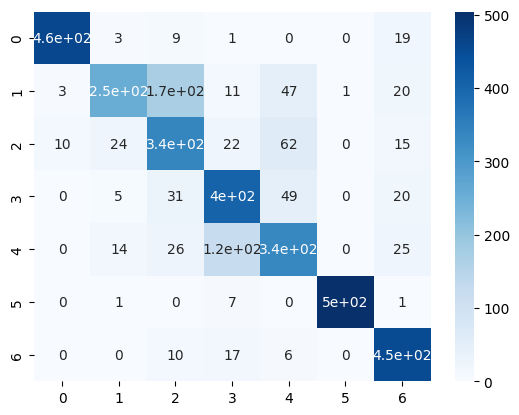

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
batch_size = 64
add_epochs = 1
history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = add_epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_validate.shape[0] // batch_size),
                              callbacks=[reduce_lr])

/var/folders/5l/_xcxp8dj3jg8wqbs9w6t88600000gn/T/ipykernel_4292/2022236307.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),


175/175 [==============================] - 92s 523ms/step - loss: 0.6755 - accuracy: 0.7432 - mse: 0.0501 - mape: 50162144.0000 - rmse: 0.1660 - val_loss: 0.5511 - val_accuracy: 0.7871 - val_mse: 0.0410 - val_mape: 39787368.0000 - val_rmse: 0.1361 - lr: 0.0010


In [ ]:
model.save('custome.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
batch_size = 64
add_epochs = 10
# history = model.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size),
#                     epochs=epochs,
#                     validation_data=val_datagen.flow(x_validate, y_validate),
#                     verbose=1,
#                     steps_per_epoch=(x_train.shape[0] // batch_size),
#                     validation_steps=(x_validate.shape[0] // batch_size),
#                     callbacks=[reduce_lr])

history = model.fit_generator(augmented_data.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, 
                              verbose = 1,
                              class_weight = class_weights,
                              validation_data = (x_validate, y_validate), 
                              steps_per_epoch = steps_per_epoch,
                              callbacks = [reduce_lr, time_callback])

/var/folders/5l/_xcxp8dj3jg8wqbs9w6t88600000gn/T/ipykernel_4292/2861249267.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augmented_data.flow(x_train, y_train, batch_size = batch_size),


Epoch 1/50
   5/1120 [..............................] - ETA: 3:29:55 - loss: 0.8522 - accuracy: 0.7406 - mse: 0.0509 - mape: 48977812.0000 - rmse: 0.1646